In [99]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [101]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",59.702306,7.462788,16.866328,8
Azure Functions + Visual Studio,158.905142,52.968381,132.955012,3
Azure AD Authentication,364.486869,30.373906,98.962171,12
Logging in Python,366.759861,26.197133,73.415933,14
Email Auth and Security,407.413038,50.926630,125.028401,8
Azure Private DNS,842.711962,44.353261,117.343968,19
Debugging in VS Code,849.182742,77.198431,207.335515,11
C# Basics,921.257762,29.717992,101.075960,31
Azure Functions + PP365,1270.955866,60.521708,185.802641,21
Terraform,1316.098324,54.837430,276.340828,24


# Histogram

sum of ages: ~32108.32


<Axes: >

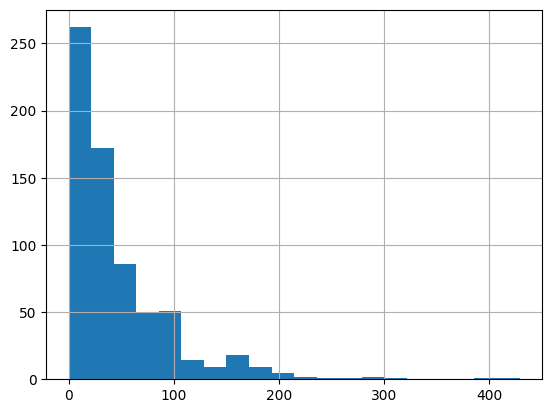

In [102]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~32108.32


<Axes: >

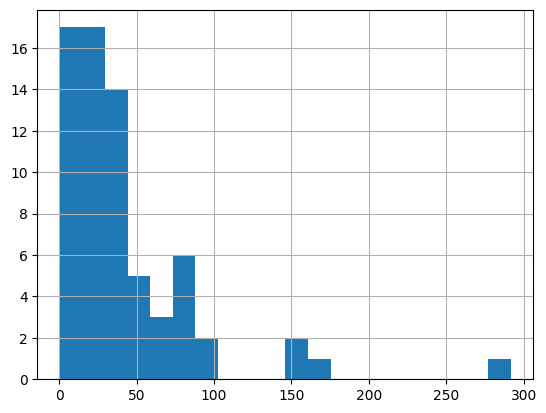

In [103]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [104]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [105]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [106]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [107]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [108]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [109]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [110]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [111]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [112]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 685
Total card age: 32108.32


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
572,RAG Project,Patch / Monkeypatch\nTemporary override of cod...,af8ef6db627eccd7c2b31be4a5423bc8,-292.106101,-82.782227,292.106101,1324.515632,0.986888,0,0
114,RAG Project,Config Object\nA centralized dictionary or str...,314d3a9674b2e5191a21c7dbc964a764,-177.892719,-82.782227,292.106101,1324.515632,0.986888,3,0
350,RAG Project,Blueprint\nA modular way to organize route han...,f860058819c5db5a8ee709fa4887e934,-71.079900,-82.782227,292.106101,1324.515632,0.986888,6,0
573,RAG Project,Access Control\nLogic that determines who can ...,e019ebe2eab5f78af0d9498c5b7ddbbc,-25.245796,-82.782227,292.106101,1324.515632,0.986888,9,0
570,RAG Project,__init__.py\nA special file that makes a direc...,ef6b8d7fc2f47f79e2b780164d231d15,-17.075220,-82.782227,292.106101,1324.515632,0.986888,12,0
571,RAG Project,Quart\nA Python web framework like Flask but w...,11660c33096c6150cc478cb8bd9a72a3,-5.714237,-82.782227,292.106101,1324.515632,0.986888,15,0
340,Debugging in VS Code,Hot Reloading\nA feature in some debuggers and...,4f1abec2cf3c58532351639c4f24b9d2,-207.335515,-77.198431,207.335515,849.182742,0.167690,0,0
103,Debugging in VS Code,Stack Trace\nA report that provides detailed i...,91024be8d7cdc8436214e3118e616d00,-82.812929,-77.198431,207.335515,849.182742,0.167690,3,0
104,Debugging in VS Code,Watch Expression\nA tool in a debugger that al...,0e46fc6bd39ab84b226e66f912eb39f3,-42.022767,-77.198431,207.335515,849.182742,0.167690,6,0
564,Debugging in VS Code,Step Over\nA debugging feature that allows you...,e8a81b42a0247e7bc1a28364d9d8cc14,-1.670139,-77.198431,207.335515,849.182742,0.167690,9,0


## Age Max

In [113]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [114]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [115]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [116]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
322,PnP PowerShell,Get-PnPListItem (PnP.PowerShell)\nFetches item...,a295fdb6e499a07c6a69b084bf979f77,-428.674619,-54.176819,428.674619,3250.609160,0.253222,0,0
378,Asynchronous Python,Awaitable\nAny object in Python that can be us...,56b47f1b55955533a2140918db6d5be0,-401.751023,-63.214085,401.751023,2907.847921,0.650245,0,0
508,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,-314.712285,-63.577509,314.712285,2352.367840,0.841183,0,0
572,RAG Project,Patch / Monkeypatch\nTemporary override of cod...,af8ef6db627eccd7c2b31be4a5423bc8,-292.106101,-82.782227,292.106101,1324.515632,0.986888,0,0
296,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-291.673777,-42.845554,291.673777,2913.497640,0.517031,0,0
237,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-276.340828,-54.837430,276.340828,1316.098324,0.233268,0,0
492,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,-244.857005,-68.208399,244.857005,2182.668782,0.748444,0,0
323,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,-231.627758,-54.176819,428.674619,3250.609160,0.253222,1,1
115,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,-216.458500,-82.782227,292.106101,1324.515632,0.986888,1,1
626,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,-211.788633,-55.668106,211.788633,1447.370760,0.833647,0,0


In [117]:
existing_cards.head(10).sum()

head                   RAG ProjectRAG ProjectRAG ProjectRAG ProjectRA...
body                   Patch / Monkeypatch\nTemporary override of cod...
hash                   af8ef6db627eccd7c2b31be4a5423bc8314d3a9674b2e5...
age                                                          -922.955323
subject_mean_age                                             -805.487086
subject_highest_age                                          2581.978668
subject_age_sum                                             11343.824758
head_random_roll                                                6.592085
count                                                                 63
n_fold                                                                 0
dtype: object

In [118]:
existing_cards['age'].mean()

-46.87345877625181